In [ ]:
pip install pyDOE

In [ ]:
%tensorflow_version 1.x  

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, x20, u0, v0, u20, v20, tb, X_f, X_f2, layers, lb, ub, lb2, ub2 ):
        
        m=0.5
        X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
        X20 = np.concatenate((x20, 0*x20), 1) # (x0, 0)
        
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        X_m = np.concatenate((0*tb + m, tb), 1) # (lb[0], tb)
        
        self.lb = lb
        self.ub = ub

        self.lb2 = lb2
        self.ub2 = ub2


        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]

        self.x20 = X20[:,0:1]
        self.t20 = X20[:,1:2]

        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]

        self.x_m = X_m[:,0:1]
        self.t_m = X_m[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.x2_f = X_f2[:,0:1]
        self.t2_f = X_f2[:,1:2]
        
        self.u0 = u0
        self.v0 = v0

        self.u20 = u20
        self.v20 = v20

        k1 = 3.15E-5
        k2 = 9.4E-6

        # Initialize NNs
        self.layers = layers
        self.weights_u, self.biases_u = self.initialize_NN_u(layers)
        self.weights_v, self.biases_v = self.initialize_NN_v(layers)
        
        self.weights_u2, self.biases_u2 = self.initialize_NN_u2(layers)
        self.weights_v2, self.biases_v2 = self.initialize_NN_v2(layers)
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.x20_tf = tf.placeholder(tf.float32, shape=[None, self.x20.shape[1]])
        self.t20_tf = tf.placeholder(tf.float32, shape=[None, self.t20.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])

        self.u20_tf = tf.placeholder(tf.float32, shape=[None, self.u20.shape[1]])
        self.v20_tf = tf.placeholder(tf.float32, shape=[None, self.v20.shape[1]])
        
        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])

        self.x_m_tf = tf.placeholder(tf.float32, shape=[None, self.x_m.shape[1]])
        self.t_m_tf = tf.placeholder(tf.float32, shape=[None, self.t_m.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        self.x2_f_tf = tf.placeholder(tf.float32, shape=[None, self.x2_f.shape[1]])
        self.t2_f_tf = tf.placeholder(tf.float32, shape=[None, self.t2_f.shape[1]])


        self.um_pred, self.u_x_m_pred = self.net_u(self.x_m_tf, self.t_m_tf)
        self.vm_pred, self.v_x_m_pred = self.net_v(self.x_m_tf, self.t_m_tf)
        
        self.u2m_pred, self.u2_x_m_pred = self.net_u2(self.x_m_tf, self.t_m_tf)
        self.v2m_pred, self.v2_x_m_pred = self.net_v2(self.x_m_tf, self.t_m_tf)

        self.u0_pred, _ = self.net_u(self.x0_tf, self.t0_tf)
        self.v0_pred, _ = self.net_v(self.x0_tf, self.t0_tf)
        self.u20_pred, _ = self.net_u2(self.x20_tf, self.t20_tf)
        self.v20_pred, _ = self.net_v2(self.x20_tf, self.t20_tf)
        
        _, self.u_x_lb_pred = self.net_u(self.x_lb_tf, self.t_lb_tf)
        _, self.v_x_lb_pred = self.net_v(self.x_lb_tf, self.t_lb_tf)
        _, self.u2_x_ub_pred = self.net_u2(self.x_lb_tf, self.t_lb_tf)
        _, self.v2_x_ub_pred = self.net_v2(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred, self.f_v_pred = self.net_f_uv(self.x_f_tf, self.t_f_tf)
        self.f_u2_pred, self.f_v2_pred = self.net_f_uv2(self.x2_f_tf, self.t2_f_tf)
        

        # Loss
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) + \
                    tf.reduce_mean(tf.square(self.u20_tf - self.u20_pred)) + \
                    tf.reduce_mean(tf.square(self.v20_tf - self.v20_pred)) + \
                    tf.reduce_mean(tf.square(self.u_x_lb_pred - self.u2_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_x_lb_pred - self.v2_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.um_pred - self.u2m_pred))+ \
                    tf.reduce_mean(tf.square(k1*((self.um_pred+1)/(self.vm_pred+1))*self.u_x_m_pred - k2*((self.u2m_pred+1)/(self.v2m_pred+1))*self.u2_x_m_pred)) +\
                    tf.reduce_mean(tf.square(self.f_u_pred)) + tf.reduce_mean(tf.square(self.f_v_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u2_pred)) + tf.reduce_mean(tf.square(self.f_v2_pred))
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN_u(self, layers):        
        weights_u = []
        biases_u = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W_u = self.xavier_init(size=[layers[l], layers[l+1]])
            b_u = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights_u.append(W_u)
            biases_u.append(b_u)        
        return weights_u, biases_u

    def initialize_NN_v(self, layers):        
        weights_v = []
        biases_v = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W_v = self.xavier_init(size=[layers[l], layers[l+1]])
            b_v = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights_v.append(W_v)
            biases_v.append(b_v)        
        return weights_v, biases_v    

    def initialize_NN_u2(self, layers):
        weights_u2 = []
        biases_u2 = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W_u2 = self.xavier_init(size=[layers[l], layers[l+1]])
            b_u2 = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights_u2.append(W_u2)
            biases_u2.append(b_u2)        
        return weights_u2, biases_u2

    def initialize_NN_v2(self, layers):        
        weights_v2 = []
        biases_v2 = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W_v2 = self.xavier_init(size=[layers[l], layers[l+1]])
            b_v2 = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights_v2.append(W_v2)
            biases_v2.append(b_v2)        
        return weights_v2, biases_v2        
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net_u(self, X, weights_u, biases_u):
        num_layers = len(weights_u) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W_u = weights_u[l]
            b_u = biases_u[l]
            H = tf.tanh(tf.add(tf.matmul(H, W_u), b_u))
        W_u = weights_u[-1]
        b_u = biases_u[-1]
        Y = tf.add(tf.matmul(H, W_u), b_u)
        return Y
    
    def net_u(self, x, t):
        X = tf.concat([x,t],1)
        
        u = self.neural_net_u(X, self.weights_u, self.biases_u)
        
        u_x = tf.gradients(u, x)[0]
        
        return u, u_x


    def neural_net_v(self, X, weights_v, biases_v):
        num_layers = len(weights_v) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W_v = weights_v[l]
            b_v = biases_v[l]
            H = tf.tanh(tf.add(tf.matmul(H, W_v), b_v))
        W_v = weights_v[-1]
        b_v = biases_v[-1]
        Y = tf.add(tf.matmul(H, W_v), b_v)
        return Y

    def net_v(self, x, t):
        X = tf.concat([x,t],1)
        
        v = self.neural_net_v(X, self.weights_v, self.biases_v)
        
        v_x = tf.gradients(v, x)[0]
        
        return v, v_x


    def net_f_uv(self, x, t):
        
        u,u_x = self.net_u(x,t)

        v,v_x = self.net_v(x,t)
        
        
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        

        v_t = tf.gradients(v, t)[0]
        v_xx = tf.gradients(v_x, x)[0]

        ce=2.1E-5*(u+1)
        cl=2.5E-3
        G=0.000026
        k=3.15E-5
        tp=0.1
        delta=0.153
        R=0.93
        J=1.666667E-2
        pow = x/delta+2.77*((t-2*tp)/(tp))**2
        sp = (0.94)*((1-R)/(tp*delta))*J
        S= (sp/ce)*tf.math.exp(-pow)
      
        k_ce = 1.50*(1/(u+1))
        f_u = u_t - k_ce*((u+1)/(v+1))*u_xx - (k_ce)*(u_x*(v+1)-v_x*(u+1))/((v+1)**2)*(u_x) + (G/ce)*(u-v) - S
        
        f_v = v_t - (G/cl)*(u-v)

        return f_u, f_v

    def neural_net_u2(self, X, weights_u2, biases_u2):
        num_layers = len(weights_u2) + 1
        
        H = 2.0*(X - self.lb2)/(self.ub2 - self.lb2) - 1.0
        for l in range(0,num_layers-2):
            W_u2 = weights_u2[l]
            b_u2 = biases_u2[l]
            H = tf.tanh(tf.add(tf.matmul(H, W_u2), b_u2))
        W_u2 = weights_u2[-1]
        b_u2 = biases_u2[-1]
        Y = tf.add(tf.matmul(H, W_u2), b_u2)
        return Y
    
    def net_u2(self, x, t):
        X = tf.concat([x,t],1)
        
        u2 = self.neural_net_u2(X, self.weights_u2, self.biases_u2)
        
        u2_x = tf.gradients(u2, x)[0]
        
        return u2, u2_x

    def neural_net_v2(self, X, weights_v2, biases_v2):
        num_layers = len(weights_v2) + 1
        
        H = 2.0*(X - self.lb2)/(self.ub2 - self.lb2) - 1.0
        for l in range(0,num_layers-2):
            W_v2 = weights_v2[l]
            b_v2 = biases_v2[l]
            H = tf.tanh(tf.add(tf.matmul(H, W_v2), b_v2))
        W_v2 = weights_v2[-1]
        b_v2 = biases_v2[-1]
        Y = tf.add(tf.matmul(H, W_v2), b_v2)
        return Y


    def net_v2(self, x, t):
        X = tf.concat([x,t],1)
        
        v2 = self.neural_net_v2(X, self.weights_v2, self.biases_v2)
        
        v2_x = tf.gradients(v2, x)[0]
        
        return v2, v2_x
    
    
    def net_f_uv2(self, x, t):

        u2,u2_x = self.net_u2(x,t)
        
        v2,v2_x = self.net_v2(x,t)
        
        u2_t = tf.gradients(u2, t)[0]
        u2_xx = tf.gradients(u2_x, x)[0]
        

        v2_t = tf.gradients(v2, t)[0]
        v2_xx = tf.gradients(v2_x, x)[0]

        ce2=5.8E-5*(u2+1)
        cl2=3.3E-3
        G2 = 0.00042
        k2=9.4E-6
        tp=0.1
        delta=0.153
        R=0.93
        J=1.666667E-2
        pow = x/delta+2.77*((t-2*tp)/(tp))**2
        sp = (0.94)*((1-R)/(tp*delta))*J
        S= (sp/ce2)*tf.math.exp(-pow)
        
        k_ce2 = 1.62E-1*(1/(u2+1))
        f_u2 = u2_t - k_ce2*((u2+1)/(v2+1))*u2_xx - (k_ce2)*(u2_x*(v2+1)-v2_x*(u2+1))/((v2+1)**2)*(u2_x) + (G2/ce2)*(u2-v2) - S
        f_v2 = v2_t - (G2/cl2)*(u2-v2)

        return f_u2, f_v2
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.x20_tf: self.x20, self.t20_tf: self.t20,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.u20_tf: self.u20, self.v20_tf: self.v20,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_m_tf: self.x_m, self.t_m_tf: self.t_m, 
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f,
                   self.x2_f_tf: self.x2_f, self.t2_f_tf: self.t2_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star, X_star2):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)

        tf_dict = {self.x20_tf: X_star2[:,0:1], self.t20_tf: X_star2[:,1:2]}
        
        u_star2 = self.sess.run(self.u20_pred, tf_dict)  
        v_star2 = self.sess.run(self.v20_pred, tf_dict)  
        
        
        tf_dict = {self.x2_f_tf: X_star2[:,0:1], self.t2_f_tf: X_star2[:,1:2]}
        
        f_u_star2 = self.sess.run(self.f_u2_pred, tf_dict)
        f_v_star2 = self.sess.run(self.f_v2_pred, tf_dict)
               
        return u_star, v_star, f_u_star, f_v_star, u_star2, v_star2, f_u_star2, f_v_star2
    
if __name__ == "__main__": 
     
    noise = 0.0        
    
    # Doman bounds
    lb = np.array([0.0, 0.0])
    ub = np.array([0.5, 1.0])
    
    lb2 = np.array([0.5, 0.0])
    ub2 = np.array([1.0, 1.0])


    
    N0 = 50
    N_b = 50
    N_f = 20000
    N_f2 = 20000
    
    layers = [2, 80, 80, 80, 80, 80,  1]
        
    t = np.linspace(0.0,1.0,300).flatten()[:,None]
    x = np.linspace(0.0,0.5,100).flatten()[:,None]
    x2 = np.linspace(0.5,1.0,100).flatten()[:,None]
    ui = np.linspace(0.0,0.0,100).flatten()[:,None] # based on size of X_star
    vi = ui
    u2i = ui
    v2i = ui
    Exact_u = ui
    Exact_v = vi
    Exact_u2 = u2i
    Exact_v2 = v2i
    
    X, T = np.meshgrid(x,t)
    X2, T = np.meshgrid(x2,t)
    

    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact_u.T.flatten()[:,None]
    v_star = Exact_v.T.flatten()[:,None]
    
    X_star2 = np.hstack((X2.flatten()[:,None], T.flatten()[:,None]))
    u_star2 = Exact_u2.T.flatten()[:,None]
    v_star2 = Exact_v2.T.flatten()[:,None]
    


    ###########################
    
    idx_x = np.random.choice(x.shape[0], N0, replace=False)
    x0 = x[idx_x,:]
    u0 = Exact_u[idx_x,0:1]
    v0 = Exact_v[idx_x,0:1]
    
    x20 = x2[idx_x,:]
    u20 = Exact_u2[idx_x,0:1]
    v20 = Exact_v2[idx_x,0:1]
    
    idx_t = np.random.choice(t.shape[0], N_b, replace=False)
    tb = t[idx_t,:]
    
    X_f = lb + (ub-lb)*lhs(2, N_f)
    
    
    X_f2 = lb2 + (ub2-lb2)*lhs(2, N_f2)
    

            
    model = PhysicsInformedNN(x0, x20, u0, v0, u20, v20, tb, X_f, X_f2, layers, lb, ub, lb2, ub2)
             
    start_time = time.time()                
    model.train(50000)
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))
    
        
    u_pred, v_pred, f_u_pred, f_v_pred, u2_pred, v2_pred, f_u2_pred, f_v2_pred = model.predict(X_star, X_star2)
    
   
    
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
    
    U2_pred = griddata(X_star2, u2_pred.flatten(), (X2, T), method='cubic')
    V2_pred = griddata(X_star2, v2_pred.flatten(), (X2, T), method='cubic')
    
    FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
    FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')     
    
    FU2_pred = griddata(X_star2, f_u2_pred.flatten(), (X2, T), method='cubic')
    FV2_pred = griddata(X_star2, f_v2_pred.flatten(), (X2, T), method='cubic')     
    

    

Streaming output truncated to the last 5000 lines.
Loss: 9.591941e-05
Loss: 9.5903284e-05
Loss: 9.5982585e-05
Loss: 9.589967e-05
Loss: 9.588592e-05
Loss: 9.587714e-05
Loss: 9.586919e-05
Loss: 9.585646e-05
Loss: 9.5845346e-05
Loss: 9.583325e-05
Loss: 9.5827774e-05
Loss: 9.581934e-05
Loss: 9.581252e-05
Loss: 9.579925e-05
Loss: 9.57834e-05
Loss: 9.5774e-05
Loss: 9.576961e-05
Loss: 9.575683e-05
Loss: 9.574395e-05
Loss: 9.574078e-05
Loss: 9.573734e-05
Loss: 9.5726624e-05
Loss: 9.571863e-05
Loss: 9.5711024e-05
Loss: 9.570249e-05
Loss: 9.56856e-05
Loss: 9.567498e-05
Loss: 9.566694e-05
Loss: 9.566013e-05
Loss: 9.565082e-05
Loss: 9.563936e-05
Loss: 9.562903e-05
Loss: 9.562322e-05
Loss: 9.561726e-05
Loss: 9.560567e-05
Loss: 9.55968e-05
Loss: 9.55899e-05
Loss: 9.5577154e-05
Loss: 9.556374e-05
Loss: 9.56167e-05
Loss: 9.555578e-05
Loss: 9.554337e-05
Loss: 9.553531e-05
Loss: 9.552475e-05
Loss: 9.5517586e-05
Loss: 9.550585e-05
Loss: 9.5510084e-05
Loss: 9.549807e-05
Loss: 9.54897e-05
Loss: 9.547864e-0

In [ ]:
U_new = U_pred*300+300
V_new = V_pred*300+300

U2_new = U2_pred*300+300
V2_new = V2_pred*300+300

U_val = np.hstack((U_new, U2_new))
V_val = np.hstack((V_new, V2_new))


In [ ]:
np.savetxt('elec_new.out', U_val, delimiter=',')
np.savetxt('latt_new.out', V_val, delimiter=',')
from google.colab import files
files.download('elec_new.out')
files.download('latt_new.out')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

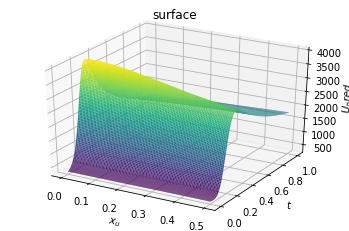

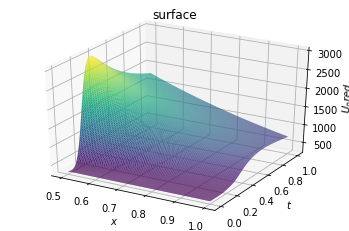

In [ ]:
    fig = plt.figure()
    X, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, U_new, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_u$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    plt.savefig('surf.pdf')

    fig = plt.figure()
    X2, T = np.meshgrid(x2, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X2, T, U2_new, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    plt.savefig('surf.pdf')



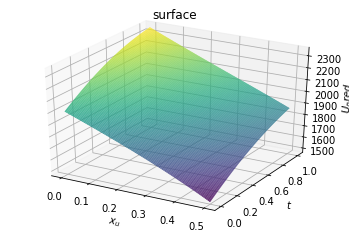

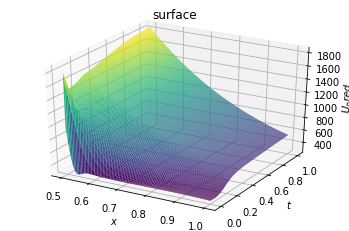

In [ ]:
    fig = plt.figure()
    X, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, U_new, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_u$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    plt.savefig('surf.pdf')

    fig = plt.figure()
    X2, T = np.meshgrid(x2, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X2, T, U2_new, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    plt.savefig('surf.pdf')



In [ ]:
s=t*1

In [ ]:
s[199]

array([1.])

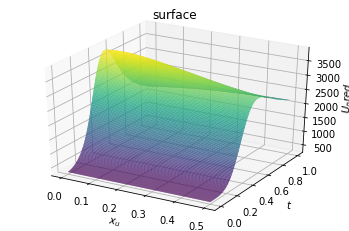

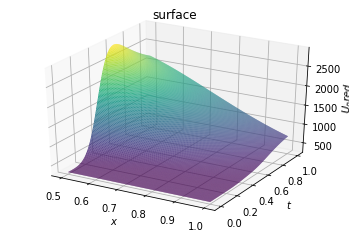

In [ ]:
    fig = plt.figure()
    X, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, U_new, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_u$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    plt.savefig('surf.pdf')

    fig = plt.figure()
    X2, T = np.meshgrid(x2, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X2, T, U2_new, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    plt.savefig('surf.pdf')



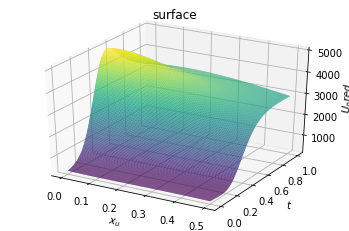

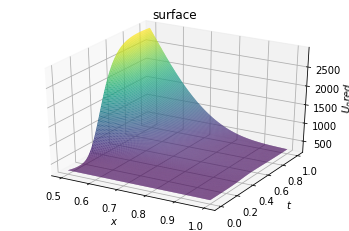

In [ ]:
    fig = plt.figure()
    X, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, U_new, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_u$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    plt.savefig('surf.pdf')

    fig = plt.figure()
    X2, T = np.meshgrid(x2, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X2, T, U2_new, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    plt.savefig('surf.pdf')


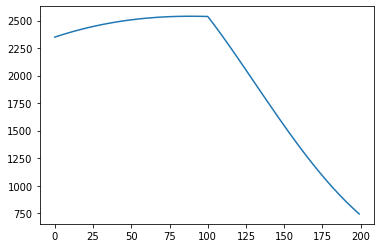

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(U_val[150,:])
plt.show()
plt.savefig("sol_t_1.jpeg")


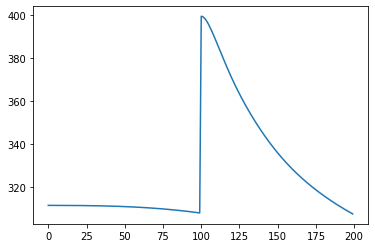

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(V_val[150,:])
plt.show()
plt.savefig("sol_t_1.jpeg")
